### Spatial Understanding with Qwen2.5-VL

This notebook showcases Qwen2.5-VL's advanced spatial localization abilities, including accurate object detection and specific target grounding within images. 

See how it integrates visual and linguistic understanding to interpret complex scenes effectively.

#### \[Setup\]

Load visualization utils.

In [10]:
# @title Plotting Util

# Get Noto JP font to display janapese characters
!apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)

import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    try:
      json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
      end_idx = bounding_boxes.rfind('"}') + len('"}')
      truncated_text = bounding_boxes[:end_idx] + "]"
      json_output = ast.literal_eval(truncated_text)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()


def plot_points(im, text, input_width, input_height):
  img = im
  width, height = img.size
  draw = ImageDraw.Draw(img)
  colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
  ] + additional_colors
  xml_text = text.replace('```xml', '')
  xml_text = xml_text.replace('```', '')
  data = decode_xml_points(xml_text)
  if data is None:
    img.show()
    return
  points = data['points']
  description = data['phrase']

  font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

  for i, point in enumerate(points):
    color = colors[i % len(colors)]
    abs_x1 = int(point[0])/input_width * width
    abs_y1 = int(point[1])/input_height * height
    radius = 2
    draw.ellipse([(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)], fill=color)
    draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color, font=font)
  
  img.show()
  

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


正在读取软件包列表... 完成%
正在分析软件包的依赖关系树... 完成%
正在读取状态信息... 完成                   
fonts-noto-cjk 已经是最新版 (1:20220127+repack1-1)。
升级了 0 个软件包，新安装了 0 个软件包， 要卸载 0 个软件包，有 57 个软件包未被升级。


Load model and processors.

In [2]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)

/cpfs01/shared/public/flash2/anaconda3/envs/qiansun_nb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`Qwen2_5_VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


Load inference function.

In [ ]:

def inference(img_url, prompt, system_prompt="You are a helpful assistant", max_new_tokens=1024):
  image = Image.open(img_url)
  messages = [
    {
      "role": "system",
      "content": system_prompt
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "image": img_url
        }
      ]
    }
  ]
  text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  print("input:\n",text)
  inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda')

  output_ids = model.generate(**inputs, max_new_tokens=1024)
  generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
  output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
  print("output:\n",output_text[0])

  input_height = inputs['image_grid_thw'][0][1]*14
  input_width = inputs['image_grid_thw'][0][2]*14

  return output_text[0], input_height, input_width

#### 1. Detect certain object in the image

Let's start with a simple scenario where we want to locate certain objects in an image.

Besides, we can further prompt the model to describe their unique characteristics or features by explicitly giving that order.

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
locate every cake and describe their features, output the bbo coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [43, 571, 209, 753], "label": "cupcake with white frosting and colorful sprinkles"},
	{"bbox_2d": [68, 408, 214, 596], "label": "cupcake with red frosting and sprinkles"},
	{"bbox_2d": [259, 392, 386, 560], "label": "cupcake with pink frosting and sprinkles"},
	{"bbox_2d": [412, 380, 518, 520], "label": "cupcake with pink frosting and sprinkles"},
	{"bbox_2d": [550, 368, 675, 543], "label": "cupcake with pink frosting and sprinkles"},
	{"bbox_2d": [306, 566, 462, 730], "label": "cupcake with white frosting and candy eyes"},
	{"bbox_2d": [365, 678, 535, 849], "label": "cupcake with white frosting and candy eyes"},
	{"bbox_2d": [138, 768, 319, 958], "label": "cupcake with white frosting and candy eyes"},
	{"bbox_

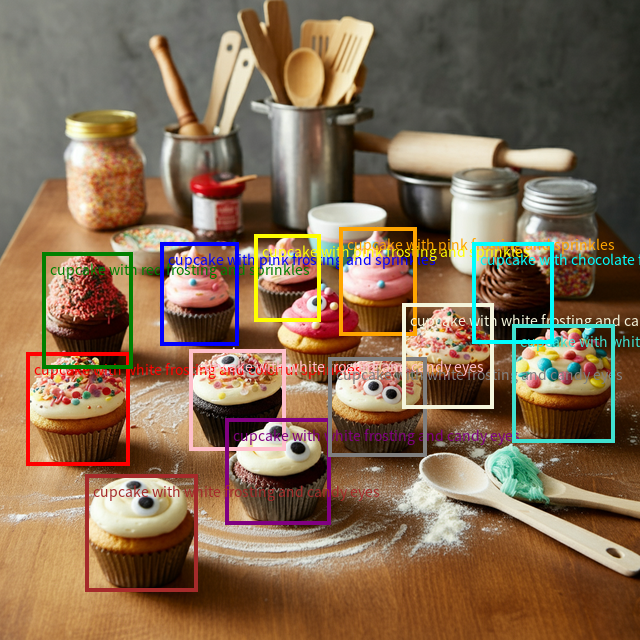

In [25]:
url = "./assets/spatial_understanding/cakes.png"

# prompt in chinese
prompt = "定位所有蛋糕并描述其特征，以json格式输出其坐标"
# prompt in english
prompt = "locate every cake and describe their features, output the bbo coordinates in JSON format."
response, input_height, input_width = inference(url, prompt)

image = Image.open(url)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)

#### 2. Detect a specific object using descriptions

Further, you can search for a specific object by using a short phrase or sentence to describe it.

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Locate the top right brown cake, output its bbox coordinates using JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [765, 394, 897, 556], "label": "top right brown cake"}
]
```
(640, 640)


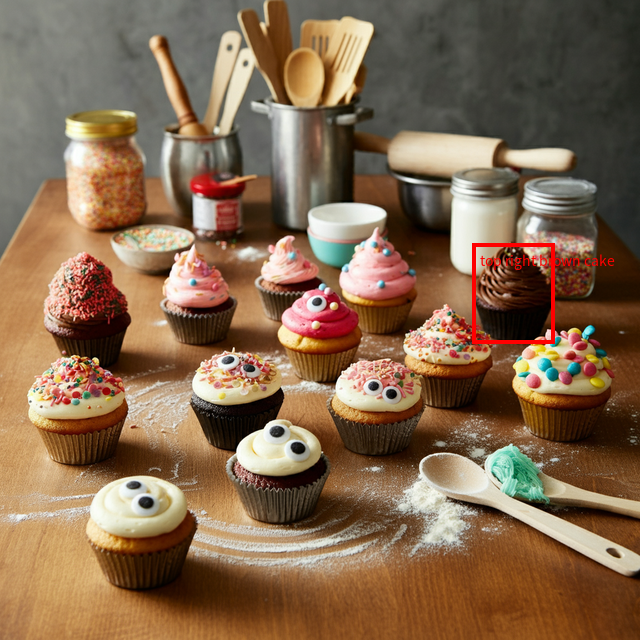

In [27]:
url = "./assets/spatial_understanding/cakes.png"

# prompt in chinses
prompt = "定位最右上角的棕色蛋糕，以JSON格式输出其bbox坐标"
# prompt in english
prompt = "Locate the top right brown cake, output its bbox coordinates using JSON format."
response, input_height, input_width = inference(url, prompt)

image = Image.open(url)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)

#### 3. Point to certain objects in xml format

In addition to the above mentioned bbox format [x1, y1, x2, y2], Qwen2.5-VL also supports point-based grounding. You can point to a specific object and the model is trained to output xml-style results.

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
point to the rolling pin on the far side of the table, output its coordinates in XML format <points x y>object</points><|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 <points x1="732" y1="249" alt="rolling pin on the far side of the table">rolling pin on the far side of the table</points>


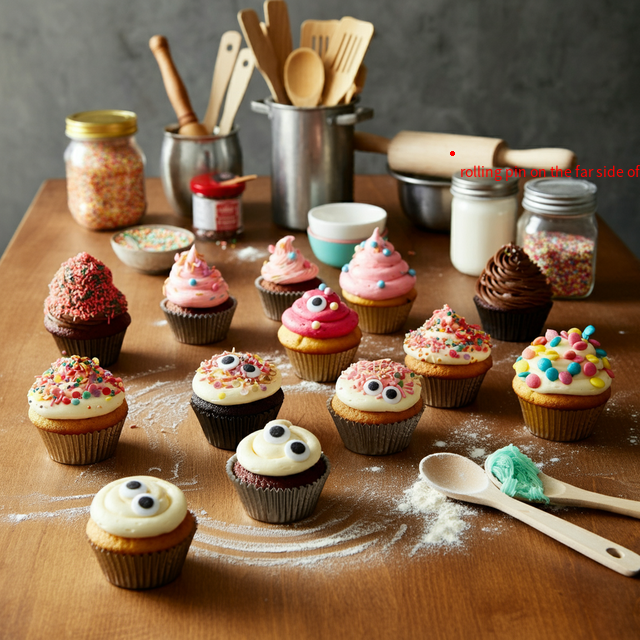

In [28]:
url = "./assets/spatial_understanding/cakes.png"

# prompt in chinese
prompt = "以点的形式定位图中桌子远处的擀面杖，以XML格式输出其坐标"
# prompt in english
prompt = "point to the rolling pin on the far side of the table, output its coordinates in XML format <points x y>object</points>"
response, input_height, input_width = inference(url, prompt)

image = Image.open(url)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_points(image, response, input_width, input_height)

#### 4. Reasoning capability

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Locate the shadow of the paper fox, report the bbox coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [1098, 1327, 1846, 1905], "label": "shadow of the paper fox"}
]
```
(640, 482)


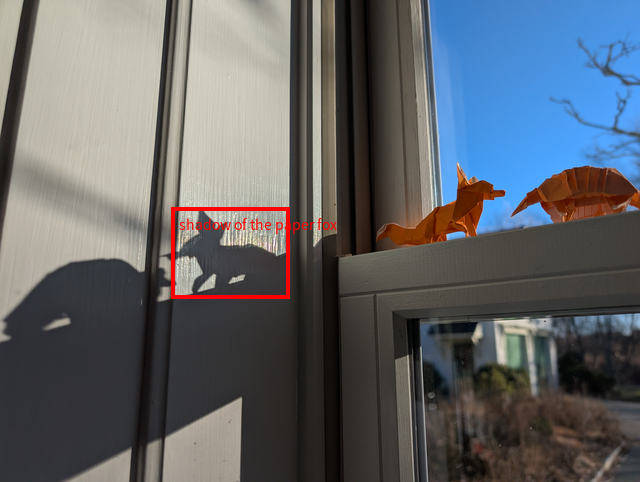

In [29]:
url = "./assets/spatial_understanding/Origamis.jpg"

# prompt in chinese
prompt = "框出图中纸狐狸的影子，以json格式输出其bbox坐标"
# prompt in english
prompt = "Locate the shadow of the paper fox, report the bbox coordinates in JSON format."
response, input_height, input_width = inference(url, prompt)

image = Image.open(url)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)

#### 5. Understand relationships across different instances

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Locate the person who act bravely, report the bbox coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [74, 58, 526, 619], "label": "person who act bravely"}
]
```
(640, 360)


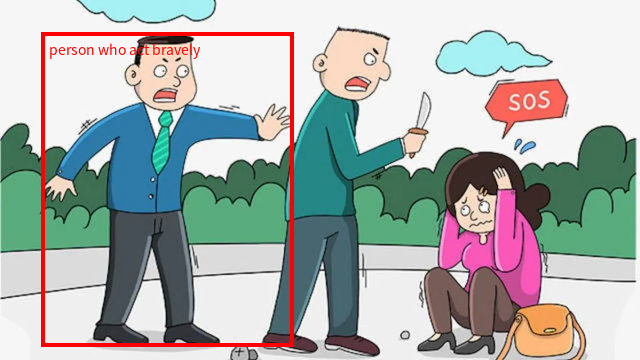

In [30]:
url = "./assets/spatial_understanding/cartoon_brave_person.jpeg"

# prompt in chinese
prompt = "框出图中见义勇为的人，以json格式输出其bbox坐标"
# prompt in english
prompt = "Locate the person who act bravely, report the bbox coordinates in JSON format."
response, input_height, input_width = inference(url, prompt)

image = Image.open(url)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)

#### 6. Find a special instance with unique characteristic (color, location, utility, ...)

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
If the sun is very glaring, which item in this image should I use? Please locate it in the image with its bbox coordinates and its name and output in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [150, 196, 308, 310], "label": "sunglasses"}
]
```
(640, 465)


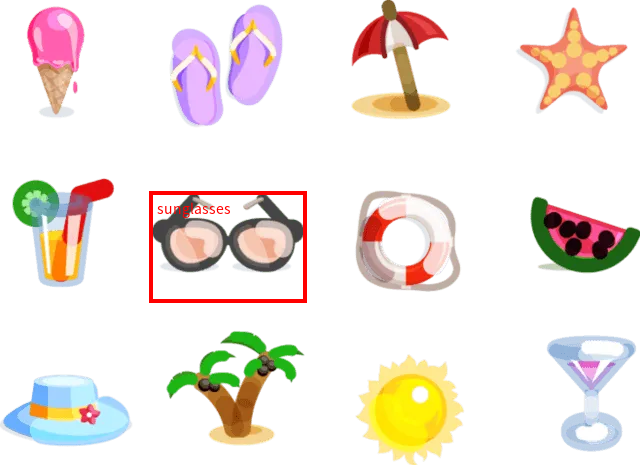

In [31]:
url = "./assets/spatial_understanding/multiple_items.png"

# prompt in chinese
prompt = "如果太阳很刺眼，我应该用这张图中的什么物品，框出该物品在图中的bbox坐标，并以json格式输出"
# prompt in english
prompt = "If the sun is very glaring, which item in this image should I use? Please locate it in the image with its bbox coordinates and its name and output in JSON format."
response, input_height, input_width = inference(url, prompt)

image = Image.open(url)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image, response, input_width, input_height)

#### 7. Use Qwen2.5-VL grounding capabilities to help counting

input:
 <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Please first output bbox coordinates and names of every item in this image in JSON format, and then answer how many items are there in the image.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 ```json
[
	{"bbox_2d": [530, 227, 644, 310], "label": "watermelon slice"},
	{"bbox_2d": [520, 5, 635, 128], "label": "starfish"},
	{"bbox_2d": [351, 0, 455, 123], "label": "umbrella"},
	{"bbox_2d": [26, 5, 90, 126], "label": "ice cream cone"},
	{"bbox_2d": [172, 5, 287, 130], "label": "flip-flops"},
	{"bbox_2d": [152, 197, 307, 310], "label": "sunglasses"},
	{"bbox_2d": [357, 196, 469, 302], "label": "life preserver"},
	{"bbox_2d": [547, 369, 644, 487], "label": "martini glass"},
	{"bbox_2d": [354, 390, 469, 498], "label": "sun"},
	{"bbox_2d": [168, 363, 307, 488], "label": "palm tree"},
	{"bbox_2d": [1, 408, 137, 488], "label": "hat"},
	{"bbox_2d": [10, 209, 117, 324], "label":

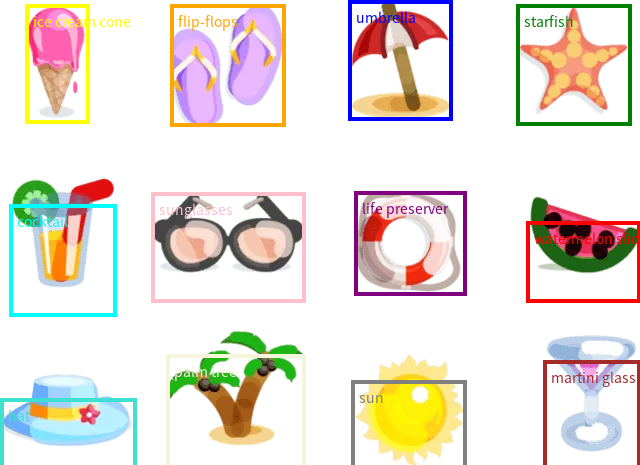

In [44]:
url = "./assets/spatial_understanding/multiple_items.png"

# prompt in chinese
prompt = "请以JSON格式输出图中所有物体bbox的坐标以及它们的名字，然后基于检测结果回答以下问题：图中物体的数目是多少？"
# prompt in english
prompt = "Please first output bbox coordinates and names of every item in this image in JSON format, and then answer how many items are there in the image."
response, input_height, input_width = inference(url, prompt)

image = Image.open(url)
image.thumbnail([640,640], Image.Resampling.LANCZOS)
plot_bounding_boxes(image,response,input_width,input_height)

#### 8. spatial understanding with designed system prompt
The above usage is based on the default system prompt. You can also change the system prompt to obtain other output format like plain text.
Qwen2.5-VL now support these formats:
* bbox-format: JSON

`{"bbox_2d": [x1, y1, x2, y2], "label": "object name/description"}`

* bbox-format: plain text

`x1,y1,x2,y2 object_name/description`

* point-format: XML

`<points x y>object_name/description</points>`

* point-format: JSON

`{"point_2d": [x, y], "label": "object name/description"}`

Change your system prompt to use plain text as output format

In [45]:
url = "./assets/spatial_understanding/cakes.png"
image = Image.open(url)
system_prompt = "As an AI assistant, you specialize in accurate image object detection, delivering coordinates in plain text format 'x1,y1,x2,y2 object'."
prompt = "用一个个框框出各个蛋糕"
response, input_height, input_width = inference(url, prompt, system_prompt=system_prompt)

input:
 <|im_start|>system
As an AI assistant, you specialize in accurate image object detection, delivering coordinates in plain text format 'x1,y1,x2,y2 object'.<|im_end|>
<|im_start|>user
用一个个框框出各个蛋糕<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

output:
 138,769,315,954 蛋糕
365,679,533,849 蛋糕
305,567,462,729 蛋糕
448,458,587,619 蛋糕
532,579,689,738 蛋糕
652,492,799,661 蛋糕
829,525,994,716 蛋糕
766,393,896,555 蛋糕
412,380,518,519 蛋糕
259,390,385,559 蛋糕
69,408,213,595 蛋糕
43,574,209,752 蛋糕

